<a href="https://colab.research.google.com/github/magikarp01/SIFNetflix/blob/master/SIF_Netflix_Dataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A notebook with code for predicting the quality of a movie or series. The notebook uses multiple regression techniques and neural networks in order to handle different kinds of predictive input.



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import math
import scipy
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import statsmodels.api as sm

import matplotlib.pyplot as plt
from tabulate import tabulate

In [ ]:
# read dataset into dataframe
df = pd.read_excel("Netflix Dataset Latest 2021.xlsx")

In [37]:
# stratify data by movie or series, since they are judged very differently
# reset index because want the indices to be in order, not skipping around
movie_dataframe = df[df["Series or Movie"] == "Movie"].reset_index()
series_dataframe =13 df[df["Series or Movie"] == "Series"].reset_index()

print(len(movie_dataframe["IMDb Score"]))
print(len(series_dataframe["IMDb Score"]))

7010
2415


First, a multiple regression between the genres a movie/series is part of and the IMDb score

In [ ]:
# functional because want to be able to work with either movie_dataframe or series_dataframe
# returns x_data, y_data
# x_data is 2d np array of whether each movie/series has a particular genre
# y_data is 1d np array of imdb reviews
def preprocess_genre_regression(dataframe):
  genre_column = dataframe["Genre"]
  imdb_column = dataframe["IMDb Score"]
  # a list of the (string) genres
  genre_list = []

  # a list of imdb reviews for each entry
  imdb_reviews = []

  # a list of the genres for each entry
  genre_data = []
  
  # process data to handle empty/bad rows
  for i in range(len(genre_column)):
    genre_cell = genre_column[i]
    if not pd.isnull(genre_cell) and not pd.isnull(imdb_column[i]):
        try:
            cell_genres = genre_cell.split(", ")
            genre_data.append(cell_genres)
            imdb_reviews.append(imdb_column[i])
        except AttributeError:
            continue

        for genre in cell_genres:
            if genre not in genre_list:
                genre_list.append(genre)

  # print(genre_list)
  genredict = {k: v for v, k in enumerate(genre_list)}

  # x_data is a 2d array, each row is an array of binary entries
  # each binary entry corresponds to if movie/series is part of a genre 
  # 0 if no and 1 if yes
  x_data = []
  for entry in genre_data:
      entry_genres = [0]*len(genre_list)
      for genre in entry:
          entry_genres[genredict[genre]] = 1
      x_data.append(entry_genres)
  x_data = np.array(x_data)
  y_data = np.array(imdb_reviews)/10

  return x_data, y_data, genre_list


In [ ]:
# Perform the multiple regression on the processed data from previous function
def train_genre_regression(x_data, y_data, test_size=0.2, random_state=101, print_output = False):
  X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=test_size, random_state=random_state)

  # creating a regression model
  model = LinearRegression()

  # fitting the model
  model.fit(X_train, y_train)

  # making predictions
  predictions = model.predict(X_test)

  # model evaluation
  print('mean_squared_error : ', mean_squared_error(y_test, predictions))
  # print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))
  print(f'model R^2: {model.score(X_test, y_test)}')
  # print(f'model coefficients: {model.coef_}')

  if print_output:
      for i in range(len(y_test)):
        print(f"predicts {predictions[i]}, actual review is {y_test[i]}")

  return model

def model_output(model, genre_list):
  # print(model.summary) 
  # coef_dic = dict(zip(genre_list, model.coef_))
  print(tabulate(zip(["Genre"] + genre_list, ["Coefficient"] + list(model.coef_)), 
                 headers="firstrow"))
  # for k, v in coef_dic.items():
  #     print(f"For genre {k}, the coefficient is {v}") 

In [ ]:
# put it all together
def genre_regression(dataframe, verbose=False):
  x_data, y_data, genre_list = preprocess_genre_regression(dataframe)
  model = train_genre_regression(x_data, y_data)
  if verbose:
    print()
    model_output(model, genre_list)
  return model

genre_regression(movie_dataframe, verbose=True)
# genre_regression(series_dataframe)

mean_squared_error :  0.006606608489484805
model R^2: 0.16982544975353442

Genre          Coefficient
-----------  -------------
Comedy        -0.0160216
Romance       -0.0126316
Drama          0.0242095
Crime          0.00948914
Fantasy       -0.000943876
Mystery        0.00364022
Thriller      -0.026328
Short          0.0323382
Action        -0.0168781
Adventure     -0.00517074
Sci-Fi        -0.00447805
Music         -0.00169727
Family        -0.0403017
Biography      0.00503447
Animation      0.0618854
War            0.0170508
History        0.000644859
Documentary    0.0512148
Horror        -0.0536533
Film-Noir     -0.0156681
Sport         -0.00701321
Western        0.0184687
Musical        0.00480804
Reality-TV     0.0367026
Adult          0.0743342
News           0.0211864
Talk-Show      0.0467816


LinearRegression()

In [ ]:
# finding the p-values of each coefficient
# shamelessly copied from https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
def show_genre_regression_results(dataframe, verbose=False):
  X, y, genre_list = preprocess_genre_regression(dataframe)
  lm = genre_regression(dataframe)
  params = np.append(lm.intercept_,lm.coef_)
  predictions = lm.predict(X)

  newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
  MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

  # Note if you don't want to use a DataFrame replace the two lines above with
  # newX = np.append(np.ones((len(X),1)), X, axis=1)
  # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

  var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
  sd_b = np.sqrt(var_b)
  ts_b = params/ sd_b

  # p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
  p_values =[2*(1-stats.t.cdf(np.abs(i),len(newX))) for i in ts_b]

  sd_b = np.round(sd_b,3)
  ts_b = np.round(ts_b,3)
  p_values = np.round(p_values,3)
  params = np.round(params,4)

  genre_list.insert(0, "Constant (not genre)")
  myDF3 = pd.DataFrame()
  # myDF3["Genre"], myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p values"] = [genre_list,params,sd_b,ts_b,p_values]
  myDF3["Genre"], myDF3["Coefficients"],myDF3["t values"],myDF3["p values"] = [genre_list,params*10,ts_b,p_values]
  return myDF3
  # if verbose:
  #   print(myDF3)
  # return params,sd_b,ts_b,p_values, genre_list

Results of Genre Multiple Regression: which genres are statistically significant, and what correlation do the significant genres have on the predicted IMDb review?

Alpha of .05 used for statistical significance

In [ ]:
from scipy.integrate._ivp.radau import P
regression_dataframe = show_genre_regression_results(series_dataframe, verbose=True)
# print(list(regression_dataframe["Genres"]))
# params,sd_b,ts_b,p_values, genre_list = show_genre_regression_results(movie_dataframe, verbose=True)
alpha = .05
def bold_style(val):
    f = "font-weight: bold" 
    #condition
    m = val["p values"] <= .05
    # DataFrame of styles
    df1 = pd.DataFrame('', index=val.index, columns=val.columns)
    # set columns by condition
    df1 = df1.mask(m, f)
    return df1

bolded_rows = []
for i in range(len(regression_dataframe["p values"])):
  if regression_dataframe["p values"][i] <= .05:
    bolded_rows.append(i)

print()

regression_dataframe.style.apply(bold_style, axis=None)

display(regression_dataframe)

print()
p_values = regression_dataframe["p values"]
genre_list = regression_dataframe["Genre"]
ts_b = regression_dataframe["t values"]
params = regression_dataframe["Coefficients"]
for i in range(1, len(p_values)):
  if p_values[i] < alpha:
    print(f"Genre {genre_list[i-1]} is statistically significant at t-score of {ts_b[i]}. " + 
          f"It's presence corresponds to a {params[i]*10} change in predicted IMDb review.")

mean_squared_error :  0.004735727235507379
model R^2: 0.009452705122505733



,Genre,Coefficients,t values,p values
0,Constant (not genre),7.304,207.060,0.000
1,Crime,0.069,1.636,0.102
2,Drama,0.207,6.456,0.000
3,Fantasy,0.109,2.584,0.010
4,Horror,-0.231,-3.690,0.000
5,Romance,0.032,0.858,0.391
6,Animation,0.087,2.190,0.029
7,Action,-0.001,-0.029,0.977
8,Comedy,0.161,5.033,0.000
9,Sci-Fi,0.025,0.516,0.606



Genre Crime is statistically significant at t-score of 6.456. It's presence corresponds to a 2.07 change in predicted IMDb review.
Genre Drama is statistically significant at t-score of 2.584. It's presence corresponds to a 1.09 change in predicted IMDb review.
Genre Fantasy is statistically significant at t-score of -3.69. It's presence corresponds to a -2.3099999999999996 change in predicted IMDb review.
Genre Romance is statistically significant at t-score of 2.19. It's presence corresponds to a 0.8699999999999999 change in predicted IMDb review.
Genre Action is statistically significant at t-score of 5.033. It's presence corresponds to a 1.61 change in predicted IMDb review.
Genre Sci-Fi is statistically significant at t-score of 3.08. It's presence corresponds to a 2.1499999999999995 change in predicted IMDb review.
Genre Short is statistically significant at t-score of -3.055. It's presence corresponds to a -1.54 change in predicted IMDb review.
Genre Biography is statistically 

In [ ]:
# find which genre is unique

movie_genre_list = ['Constant (not genre)', 'Comedy', 'Romance', 'Drama', 'Crime', 'Fantasy', 'Mystery', 'Thriller', 'Short', 'Action', 'Adventure', 'Sci-Fi', 'Music', 'Family', 'Biography', 'Animation', 'War', 'History', 'Documentary', 'Horror', 'Film-Noir', 'Sport', 'Western', 'Musical', 'Reality-TV', 'Adult', 'News', 'Talk-Show']
series_genre_list = ['Constant (not genre)', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Romance', 'Animation', 'Action', 'Comedy', 'Sci-Fi', 'History', 'War', 'Adventure', 'Short', 'Family', 'Game-Show', 'Biography', 'Mystery', 'Thriller', 'Documentary', 'Sport', 'Music', 'Reality-TV', 'Musical', 'News', 'Talk-Show', 'Western', 'Adult']

print(list(set(movie_genre_list) - set(series_genre_list)))
print(list(set(series_genre_list) - set(movie_genre_list)))

['Film-Noir']
['Game-Show']


Another model, determining whether runtime has an affect on the quality of the movie

In [ ]:
runtime_names = ["< 30 minutes", "30-60 mins", "1-2 hour", "> 2 hrs"]

# split reviews into four lists, depending on runtime length
def runtime_stratification(dataframe):
  runtime_column = dataframe["Runtime"]
  imdb_column = dataframe["IMDb Score"]
  
  # runtime_data is list of 4 arrays, each array has all imdb reviews for one runtime
  # 0 corresponding to <30 mins, 1 for 30-60 mins, 2 for 1-2 hour, 3 for > 2 hrs

  runtime_data = [[], [], [], []]
  # possible values in the runtime cell
  possible_runtimes = {"< 30 minutes": 0, "30-60 mins": 1, "1-2 hour": 2, "> 2 hrs": 3}
  # process data to handle empty/bad rows
  for i in range(len(runtime_column)):
    runtime_cell = runtime_column[i]
    if not pd.isnull(runtime_cell) and not pd.isnull(imdb_column[i]):
        try:
            runtime_data[possible_runtimes[runtime_cell]].append(imdb_column[i])
        except AttributeError:
            continue

  for i in range(4):
    runtime_data[i] = [x for x in runtime_data[i] if np.isnan(x) == False]

  for i in range(4):
    if len(runtime_data[i]) == 0:
      print(f"No entries have runtime {runtime_names[i]}")
    else:
      # print(f"For runtime {runtime_names[i]}, average IMDb score is {np.average(runtime_data[i])}, " +
      #       f"variance in IMDb score is {np.var(runtime_data[i])}")
      print(f"For runtime {runtime_names[i]}, average disparity score is {np.average(runtime_data[i])}, " +
            f"variance in disparity score is {np.var(runtime_data[i])}")


  return runtime_data


colors = ["blue", "red", "orange", "green"]
# making histograms for each runtime category
def display_runtime_graphs(runtime_data, axis_range=(0, 10)):
  fig, axs = plt.subplots(2, 2)
  # fig.suptitle("Histograms for IMDb Scores for Different Runtimes")
  fig.suptitle("Histograms of IMDB - RT/10 for Different Runtimes")
  plt.subplots_adjust(wspace=.5, hspace=.8)
  # fig.tight_layout()
  for i in range(2):
    for j in range(2):
      runtime_index = 2*i + j
      axs[i, j].hist(runtime_data[runtime_index], range=axis_range, color=colors[runtime_index])
      axs[i, j].set_title(runtime_names[runtime_index])
      axs[i,j].set(xlabel="IMDb Score")
  plt.show()

# overlaying histograms
def overlap_runtime_histograms(runtime_data, axis_range=(0, 10)):
  plt.hist(runtime_data, density=True, range=axis_range, color=colors)
  plt.legend(runtime_names)
  # plt.title("Overlapped Histogram of IMDb Reviews for each Runtime")
  plt.title("Overlapped Histogram of IMDB - RT/10 for each Runtime")
  plt.xlabel("IMDb Score")
  plt.show()

In [ ]:
print("Movies:")
movie_runtimes = runtime_stratification(movie_dataframe)
print()
print("Series:")
nan_runtime = runtime_stratification(series_dataframe)

Movies:
For runtime < 30 minutes, average disparity score is 7.076344086021504, variance in disparity score is 0.46417158052954105
For runtime 30-60 mins, average disparity score is 7.133088235294117, variance in disparity score is 0.3467728157439447
For runtime 1-2 hour, average disparity score is 6.632261768082665, variance in disparity score is 0.7887142491200274
For runtime > 2 hrs, average disparity score is 7.1072398190045245, variance in disparity score is 0.5618221810130247

Series:
For runtime < 30 minutes, average disparity score is 7.543082021541011, variance in disparity score is 0.4634711970835687
No entries have runtime 30-60 mins
No entries have runtime 1-2 hour
No entries have runtime > 2 hrs


We can illustrate our results with some histograms.

<Figure size 432x288 with 0 Axes>

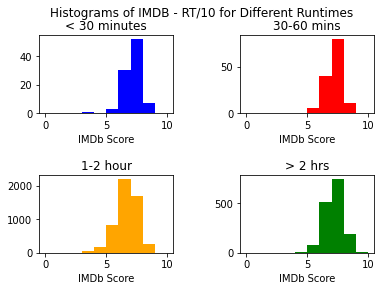

In [ ]:
plt. clf()
# show graphs
display_runtime_graphs(movie_runtimes, axis_range=(0, 10))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


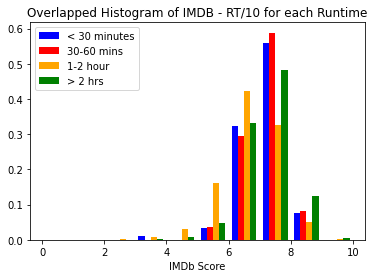

In [ ]:
overlap_runtime_histograms(movie_runtimes, axis_range=(0, 10))

Let's find out how significant these results are. We can run t-tests on the different runtimes for movies (not on series, there are no different runtimes here)

In [ ]:
# 4 t-tests, seeing if each runtime's imdb reviews are significantly different
# from the all runtime imdb reviews

all_reviews = movie_runtimes[0] + movie_runtimes[1] + movie_runtimes[2] + movie_runtimes[3]
ttests = [stats.ttest_ind(all_reviews, movie_runtimes[i]) for i in range(4)]

for i in range(4):
  print(f"For runtime {runtime_names[i]}, the t-value is {ttests[i][0]} and the p-value is {ttests[i][1]}")
print(ttests)

For runtime < 30 minutes, the t-value is -3.5442323147590495 and the p-value is 0.0003962936464760194
For runtime 30-60 mins, the t-value is -5.0358839611362045 and the p-value is 4.873121306265942e-07
For runtime 1-2 hour, the t-value is 7.4809975776502595 and the p-value is 7.880220859031242e-14
For runtime > 2 hrs, the t-value is -14.75265313573987 and the p-value is 1.169884586874494e-48
[Ttest_indResult(statistic=-3.5442323147590495, pvalue=0.0003962936464760194), Ttest_indResult(statistic=-5.0358839611362045, pvalue=4.873121306265942e-07), Ttest_indResult(statistic=7.4809975776502595, pvalue=7.880220859031242e-14), Ttest_indResult(statistic=-14.75265313573987, pvalue=1.169884586874494e-48)]


Time for something more complex. You know when you read a summary for a show/movie, and you know that it's just gonna be terrible? We could try to predict the IMDb score from the summary alone, using NLP techniques and a neural network.

In [ ]:
# encode summary into a 512-dimensional vector, that preserves semantics and meaning
# save in np array
def preprocess_summary_prediction(dataframe, hub_layer):
  summary_column = dataframe["Summary"]
  imdb_column = dataframe["IMDb Score"]

  # a list of imdb reviews for each entry
  imdb_reviews = []

  # a 2d numpy array of the encoded summaries
  summary_data = []
  
  # process data to handle empty/bad rows
  for i in range(len(summary_column)):
    # print(i)
    summary_cell = summary_column[i]
    if not pd.isnull(summary_cell) and not pd.isnull(imdb_column[i]):
        try:
            # encoded_summary = hub_layer([summary_cell])
            # summary_data.append(encoded_summary)
            summary_data.append([summary_cell])
            imdb_reviews.append(imdb_column[i])
        except AttributeError:
            continue

  summary_data = np.array(summary_data)
  imdb_reviews = np.array(imdb_reviews)/10
  return summary_data, imdb_reviews

In [ ]:
# preprocess data

embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
summary_data, imdb_reviews = preprocess_summary_prediction(series_dataframe, hub_layer)

In [ ]:
print(summary_data.shape)

(2414, 1)


In [ ]:
model = tf.keras.Sequential()
# model.add()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='relu'))
model.summary()
config = model.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________
(None,)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
print(imdb_reviews)
print(summary_data)
print(summary_data.shape)

[0.79 0.75 0.73 ... 0.84 0.8  0.68]
[['A med student with a supernatural gift tries to cash in on his abilities by facing off against ghosts, till a wandering spirit brings romance instead.']
 ['A group of social welfare workers led by their new director tries to provide necessary aid to people struggling with various problems.']
 ['The girls on Oarai’s tankery team look forward to finishing out the school year in peace, but before they know it, theyre back on the battlefield.']
 ...
 ['Stargate Command roars into action when Jack ONeill and his crew find a Stargates map that lets them combat alien maneuvers all across the galaxy.']
 ['A talented young goalkeeper tries to revive his schools lackluster team in this anime series based on the hit manga and video game.']
 ['Madagascar goes wild with holiday spirit in this set of Valentines Day and Christmas-themed tales featuring everyones favorite animal characters.']]
(2414, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    summary_data, imdb_reviews, test_size=.2, random_state=101)
# print(X_train.shape)
# print(X_test.shape)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=.2, random_state=101)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')
y_validation = np.array(y_validation).astype('float32')

print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)


(1544, 1)
(387, 1)
(483, 1)
(1544,)
(483,)
(387,)


Train the model that has been set up so far:

In [ ]:
# history = model.fit(x=X_train, y=y_train,
#                     epochs=3,
#                     validation_data=(X_validation, y_validation),
#                     verbose=1)

In [ ]:
# model.save("series_summary_imdb.h5")

OK. This model is kind of shit, ngl. Maybe a movie summary doesn't have much to do with its IMDb score.

The quality of a movie is not solely based upon its IMDb Score. IMDb is meant to represent what a general audience thinks of a movie. What about the critical reception of a movie? Rotten Tomatoes is typically a better gauge of how actual movie critics feel.

We should make a model to predict what the difference in IMDb score and Rotten Tomatoes score will be.

In [ ]:
# since I'm lazy, just going to alter the dataframe and change IMDb score to IMDb - Rotten_Tomatoes/10
def get_altered_dataframe(dataframe):
  imdb = dataframe["IMDb Score"]
  rt = dataframe["Rotten Tomatoes Score"]
  altered_dataframe = dataframe.copy(deep=True)
  altered_dataframe["IMDb Score"] = imdb - rt/10
  return altered_dataframe

# print(get_altered_dataframe(movie_dataframe)["IMDb Score"])


Re-running the genre multiple regression with the difference in reviews as the dependent variable.

In [ ]:
altered_movie_dataframe = get_altered_dataframe(movie_dataframe)
altered_series_dataframe = get_altered_dataframe(series_dataframe)

In [ ]:
regression_dataframe = show_genre_regression_results(altered_movie_dataframe, verbose=True)
# print(list(regression_dataframe["Genres"]))
# params,sd_b,ts_b,p_values, genre_list = show_genre_regression_results(movie_dataframe, verbose=True)
alpha = .05

display(regression_dataframe)

print()
p_values = regression_dataframe["p values"]
genre_list = regression_dataframe["Genre"]
ts_b = regression_dataframe["t values"]
params = regression_dataframe["Coefficients"]
for i in range(1, len(p_values)):
  if p_values[i] < alpha:
    print(f"Genre {genre_list[i-1]} is statistically significant at t-score of {ts_b[i]}. " + 
          f"It's presence corresponds to a {params[i]*10} change in predicted IMDb review.")

mean_squared_error :  0.040413250718050055
model R^2: 0.07562761780461102


,Genre,Coefficients,t values,p values
0,Constant (not genre),0.070,0.823,0.411
1,Comedy,0.132,1.882,0.060
2,Crime,0.071,0.873,0.383
3,Drama,-0.582,-8.674,0.000
4,Fantasy,0.393,4.055,0.000
5,Mystery,0.171,1.731,0.083
6,Thriller,0.523,6.768,0.000
7,Action,0.553,7.375,0.000
8,Adventure,-0.092,-1.021,0.307
9,Sci-Fi,-0.067,-0.694,0.487



Genre Crime is statistically significant at t-score of -8.674. It's presence corresponds to a -5.82 change in predicted IMDb review.
Genre Drama is statistically significant at t-score of 4.055. It's presence corresponds to a 3.93 change in predicted IMDb review.
Genre Mystery is statistically significant at t-score of 6.768. It's presence corresponds to a 5.23 change in predicted IMDb review.
Genre Thriller is statistically significant at t-score of 7.375. It's presence corresponds to a 5.53 change in predicted IMDb review.
Genre Sci-Fi is statistically significant at t-score of 6.485. It's presence corresponds to a 4.81 change in predicted IMDb review.
Genre Romance is statistically significant at t-score of 2.724. It's presence corresponds to a 3.25 change in predicted IMDb review.
Genre History is statistically significant at t-score of -10.884. It's presence corresponds to a -15.14 change in predicted IMDb review.
Genre Horror is statistically significant at t-score of -7.758. It

Re-running the runtime analysis with review difference as dependent variable

For runtime < 30 minutes, average disparity score is 0.0451612903225806, variance in disparity score is 2.8818314255983357
For runtime 30-60 mins, average disparity score is -0.8999999999999999, variance in disparity score is 1.8717647058823528
For runtime 1-2 hour, average disparity score is 0.22643735877479282, variance in disparity score is 4.622602597569926
For runtime > 2 hrs, average disparity score is 0.07271255060728743, variance in disparity score is 2.9923161238505793

For runtime < 30 minutes, the t-value is 0.37033819561329445 and the p-value is 0.7111452831527045
For runtime 30-60 mins, the t-value is 3.0648084753598996 and the p-value is 0.00218901984378713
For runtime 1-2 hour, the t-value is -1.005586605202487 and the p-value is 0.3146407342134171
For runtime > 2 hrs, the t-value is 1.7333275660400875 and the p-value is 0.08308476999036125


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


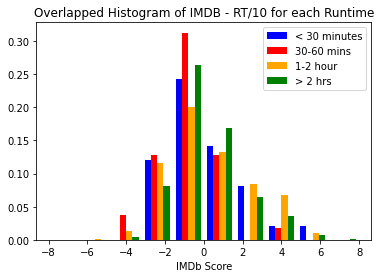

In [ ]:
altered_movie_runtimes = runtime_stratification(altered_movie_dataframe)

all_reviews = altered_movie_runtimes[0] + altered_movie_runtimes[1] \
  + altered_movie_runtimes[2] + altered_movie_runtimes[3]
ttests = [stats.ttest_ind(all_reviews, altered_movie_runtimes[i]) for i in range(4)]
print()
runtime_names = ["< 30 minutes", "30-60 mins", "1-2 hour", "> 2 hrs"]
for i in range(4):
  print(f"For runtime {runtime_names[i]}, the t-value is {ttests[i][0]} and the p-value is {ttests[i][1]}")
# print(ttests)

overlap_runtime_histograms(altered_movie_runtimes, axis_range=(-8, 8))

<Figure size 432x288 with 0 Axes>

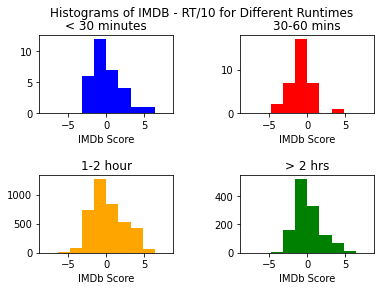

In [ ]:
plt. clf()
# show graphs
display_runtime_graphs(altered_movie_runtimes, axis_range=(-8, 8))

In [ ]:
model = tf.keras.Sequential()
# model.add()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='relu'))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 16)                8208      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
summary_data, imdb_reviews = preprocess_summary_prediction(altered_series_dataframe, hub_layer)

X_train, X_test, y_train, y_test = train_test_split(
    summary_data, imdb_reviews, test_size=.2, random_state=101)
# print(X_train.shape)
# print(X_test.shape)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=.2, random_state=101)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')
y_validation = np.array(y_validation).astype('float32')

print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)


(98, 1)
(25, 1)
(31, 1)
(98,)
(31,)
(25,)


In [ ]:
# history = model.fit(x=X_train, y=y_train,
#                     epochs=3,
#                     validation_data=(X_validation, y_validation),
#                     verbose=1)

In [ ]:
model.save("series_summary_imdb-rt.h5")

In [ ]:
def summary_analysis(dataframe, savename, epochs=10):
  model = tf.keras.Sequential()
  embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
  hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
  model.add(hub_layer)
  model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
  model.add(tf.keras.layers.Dense(1, activation='relu'))
  model.summary()

  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae'])
  
  summary_data, imdb_reviews = preprocess_summary_prediction(dataframe, hub_layer)
    
  y_pred = [np.average(imdb_reviews) for i in range(len(imdb_reviews))]
  def_loss = mean_squared_error(imdb_reviews, y_pred)
  print(f"Default loss is {def_loss}")

  X_train, X_validation, y_train, y_validation = train_test_split(
      summary_data, imdb_reviews, test_size=.2, random_state=101)
  # print(X_train.shape)
  # print(X_test.shape)

  y_train = np.array(y_train).astype('float32')
  y_validation = np.array(y_validation).astype('float32')

  history = model.fit(x=X_train, y=y_train,
                    epochs=epochs,
                    validation_data=(X_validation, y_validation),
                    verbose=1)
  
  model.save(savename)


In [ ]:
summary_analysis(movie_dataframe, "summary_nns/movie_imdb.h5")
# summary_analysis(series_dataframe, "summary_nns/series_imdb.h5")
summary_analysis(altered_movie_dataframe, "summary_nns/movie_imdb-rt.h5")
summary_analysis(altered_series_dataframe, "summary_nns/series_imdb-rt.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 16)                8208      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________
Default loss is 0.007675623558308947
Epoch 1/10


KeyboardInterrupt: ignored